In [60]:
from lib.gmm_torch.gmm import GaussianMixture
from lib.visualization import plot_distribution
import yaml
import torch
import pandas as pd

In [61]:
env_cfg = yaml.safe_load("""
entities:
    fox:
        n: 3
        mean: &standard_mean
            min: [-2, -2]
            max: [2, 2]
        var: &standard_var
            min: [0.05, 0.05]
            max: [0.3, 0.3]
        pi: &standard_pi
            min: 0
            max: 1
    wolf:
        n: 4
        mean: *standard_mean
        var: *standard_var
        pi: *standard_pi
    fairie:
        n: 2
        mean: *standard_mean
        var: *standard_var
        pi: *standard_pi
    dragon:
        n: 2
        mean: *standard_mean
        var: *standard_var
        pi: *standard_pi
    turtle:
        n: 1
        mean: *standard_mean
        var: *standard_var
        pi: *standard_pi
""")
print(env_cfg)

{'entities': {'fox': {'n': 3, 'mean': {'min': [-2, -2], 'max': [2, 2]}, 'var': {'min': [0.05, 0.05], 'max': [0.3, 0.3]}, 'pi': {'min': 0, 'max': 1}}, 'wolf': {'n': 4, 'mean': {'min': [-2, -2], 'max': [2, 2]}, 'var': {'min': [0.05, 0.05], 'max': [0.3, 0.3]}, 'pi': {'min': 0, 'max': 1}}, 'fairie': {'n': 2, 'mean': {'min': [-2, -2], 'max': [2, 2]}, 'var': {'min': [0.05, 0.05], 'max': [0.3, 0.3]}, 'pi': {'min': 0, 'max': 1}}, 'dragon': {'n': 2, 'mean': {'min': [-2, -2], 'max': [2, 2]}, 'var': {'min': [0.05, 0.05], 'max': [0.3, 0.3]}, 'pi': {'min': 0, 'max': 1}}, 'turtle': {'n': 1, 'mean': {'min': [-2, -2], 'max': [2, 2]}, 'var': {'min': [0.05, 0.05], 'max': [0.3, 0.3]}, 'pi': {'min': 0, 'max': 1}}}}


In [62]:
def sample_uniform(cfg):
    min = torch.tensor(cfg["min"]).view(-1)
    max = torch.tensor(cfg["max"]).view(-1)
    return torch.rand(len(min)) * (max - min) + min

entities = []
means = []
vars = []
pis = []

for entity, cfg in env_cfg["entities"].items():
    for _ in range(cfg["n"]):
        entities.append(entity)
        means.append(sample_uniform(cfg["mean"]).unsqueeze(0))
        vars.append(sample_uniform(cfg["var"]).unsqueeze(0))
        pis.append(sample_uniform(cfg["pi"]).unsqueeze(0))

means = torch.stack(means, dim=1)
vars = torch.stack(vars, dim=1)
pis = torch.softmax(torch.stack(pis, dim=1), 1)

df = pd.DataFrame({
    "entities": entities,
    "mean_x": means[0, :, 0],
    "mean_y": means[0, :, 1],
    "var_x": vars[0, :, 0],
    "var_y": vars[0, :, 1],
    "pi": pis[0, :, 0]
})
print(df)

gmm = GaussianMixture(
    n_components=means.shape[1],
    n_features=means.shape[2],
    mu_init=means,
    var_init=vars,
    pi_init=pis
)

samples, components = gmm.sample(20)
sample_df = pd.DataFrame({
    "entity": [entities[idx] for idx in components],
    "component": components,
    "x": samples[:, 0],
    "y": samples[:, 1]
})
print(sample_df)

   entities    mean_x    mean_y     var_x     var_y        pi
0       fox -1.318775  0.710827  0.228953  0.055409  0.071409
1       fox  1.526244  1.525764  0.080850  0.084541  0.112776
2       fox -1.079453 -1.177742  0.201267  0.103437  0.069707
3      wolf  0.119203 -1.350635  0.070661  0.294832  0.075161
4      wolf  0.416715  1.159588  0.159468  0.144992  0.097659
5      wolf  0.203461 -0.365465  0.247160  0.133082  0.120635
6      wolf  0.408905  0.315255  0.155003  0.249710  0.130687
7    fairie -0.570765 -0.756259  0.251560  0.185194  0.061374
8    fairie  0.233700 -1.855264  0.299346  0.293245  0.072841
9    dragon  0.321974  0.100467  0.233401  0.164051  0.062605
10   dragon  1.688219  1.003778  0.269506  0.247258  0.053160
11   turtle -0.422026  0.644305  0.224148  0.164442  0.071985
    entity  component         x         y
0      fox          0 -1.517672  0.733258
1      fox          0 -0.859999  0.898217
2      fox          1  1.586147  1.091250
3      fox          1  1.2

In [63]:
viewer_range = 1
viewer_position = [0, 0]

def in_range(viewer_range, viewer_position, target_position):
    viewer_position = torch.tensor(viewer_position).float().unsqueeze(0)
    target_position = torch.tensor(target_position).float().unsqueeze(0)
    dist = torch.cdist(viewer_position, target_position)
    return (dist < viewer_range).item()

sample_df["viewed"] = sample_df.apply(
    lambda col: in_range(viewer_range, viewer_position, [col["y"], col["y"]]),
    axis=1
)
print(sample_df)

    entity  component         x         y  viewed
0      fox          0 -1.517672  0.733258   False
1      fox          0 -0.859999  0.898217   False
2      fox          1  1.586147  1.091250   False
3      fox          1  1.204365  1.350782   False
4      fox          2 -1.293092 -1.520185   False
5     wolf          3  0.220316 -1.245943   False
6     wolf          3  0.356998 -1.332276   False
7     wolf          5  0.177773  0.413537    True
8     wolf          5  0.083816  0.205647    True
9     wolf          6  1.148154  0.052999    True
10    wolf          6 -0.347617  0.297335    True
11    wolf          6  1.610750  0.287645    True
12    wolf          6  0.589393  0.865160   False
13    wolf          6  0.748818  0.024321    True
14    wolf          6 -0.056104  0.744994   False
15    wolf          6 -0.082273 -0.543031    True
16  fairie          7  0.238891 -0.944396   False
17  fairie          8 -0.032061 -1.720809   False
18  dragon          9  0.143553  0.290090    True


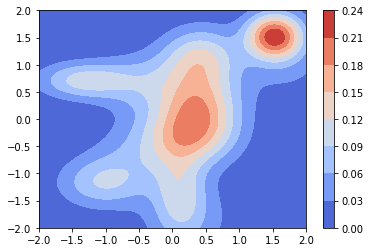

In [64]:
from lib.visualization import plot_distribution
#gmm.pi[0, :, 0][4:] = 0
plot_distribution(gmm)

turtle
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0720])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


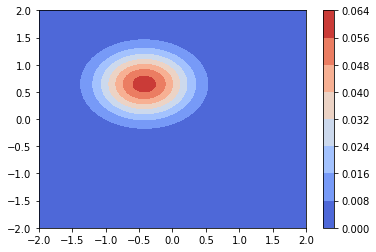

wolf
tensor([0.0000, 0.0000, 0.0000, 0.0752, 0.0977, 0.1206, 0.1307, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0])


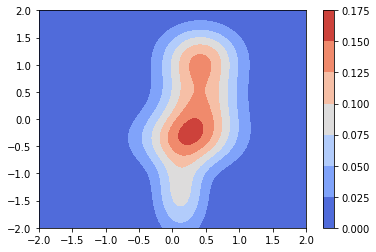

fairie
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0614, 0.0728,
        0.0000, 0.0000, 0.0000])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])


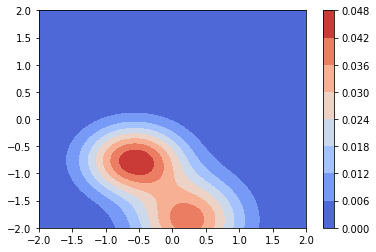

fox
tensor([0.0714, 0.1128, 0.0697, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


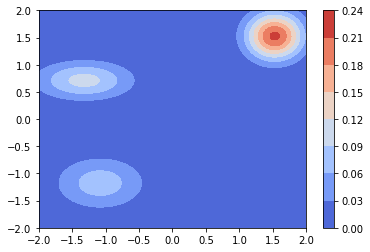

dragon
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0626, 0.0532, 0.0000])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])


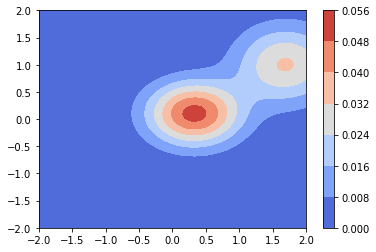

In [65]:
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt


pi_orig = gmm.pi[0, :, 0].clone()
unique_entites = set(entities)
for entity in unique_entites:
    mask = torch.tensor([int(e == entity) for e in entities])
    print(entity)

    print(pi_orig * mask)
    print(mask)
    gmm.pi[0, :, 0] = pi_orig * mask
    plot_distribution(gmm)
    plt.show()
gmm.pi[0, :, 0] = pi_orig


In [1]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoder


class GenomeEncoder(nn.Model):

    def __init__(self):
        self.encoder = TransformerEncoder(args)
        self.decoder = TransformerDecoder(args)
        self.host_embeddings = nn.parameter(n_hosts, 2000) # One big learnable marix

    def forward(genome):
        genome_encodings = self.encoder(genome)
        host_likelihoods = self.decoder(tgt=self.host_embeddings, memory=genome_encodings)

        return host_likelihoods

def loss_fn(ground_truth_infections, host_likehoods):
    